In [1]:
from transformers.trainer_utils import set_seed
set_seed(42)

In [4]:
from pprint import pprint
from datasets import load_dataset

train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")
pprint(train_dataset[0])

Generating test split: 100%|██████████| 1781/1781 [00:00<00:00, 1005661.74 examples/s]


{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [5]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


In [6]:
from transformers import AutoTokenizer

model_name = "cl-tohoku/bert-base-japanese-v3"

tokenizer = AutoTokenizer.from_pretrained(model_name)

print(type(tokenizer).__name__)

loading file vocab.txt from cache at /Users/satsuki/.cache/huggingface/hub/models--cl-tohoku--bert-base-japanese-v3/snapshots/65243d6e5629b969c77309f217bd7b1a79d43c7e/vocab.txt
loading file spiece.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/satsuki/.cache/huggingface/hub/models--cl-tohoku--bert-base-japanese-v3/snapshots/65243d6e5629b969c77309f217bd7b1a79d43c7e/tokenizer_config.json
loading file tokenizer.json from cache at None


BertJapaneseTokenizer


/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [11]:
encoded_input =  tokenizer("これはテストです。")
print(type(encoded_input).__name__)

BatchEncoding


In [12]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [14]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

100%|██████████| 20149/20149 [00:01<00:00, 13018.59it/s]


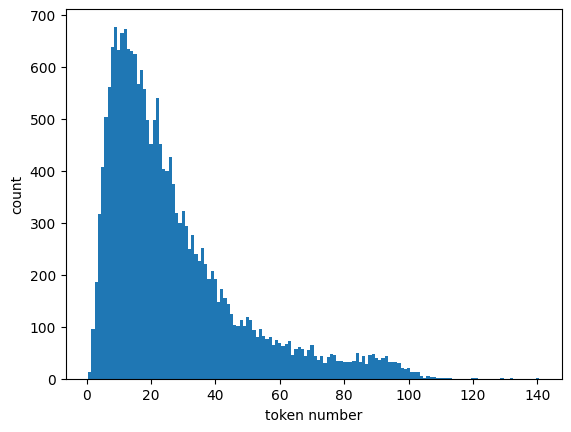

100%|██████████| 1608/1608 [00:00<00:00, 9481.74it/s]


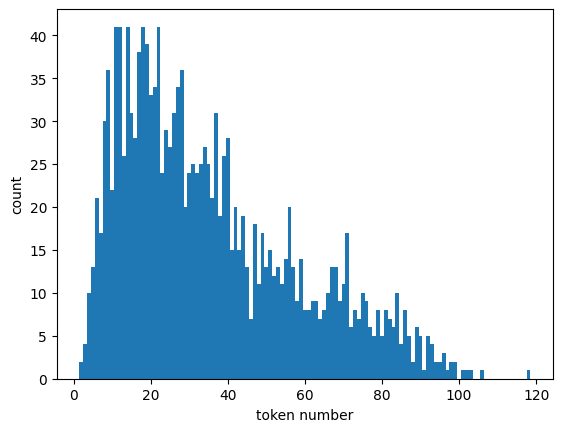

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

def visualize_text_length(dataset: Dataset):
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("token number")
    plt.ylabel("count")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

In [18]:
for data in valid_dataset:
    if len(tokenizer.tokenize(data["sentence"])) < 10:
        pprint(data)
        break

{'datetime': '2020/5/15 17:35',
 'label': 1,
 'sentence': 'よくわからない連携。',
 'user_id': 26}


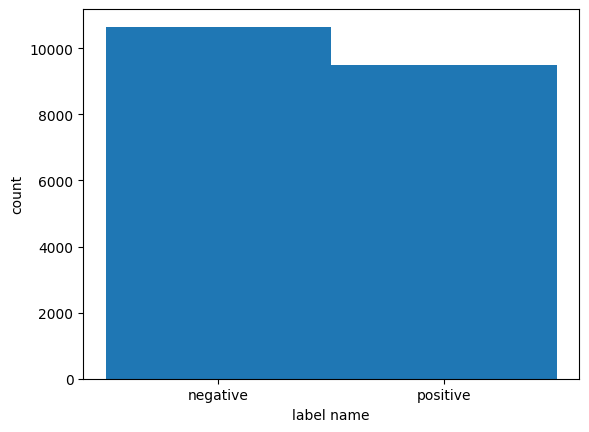

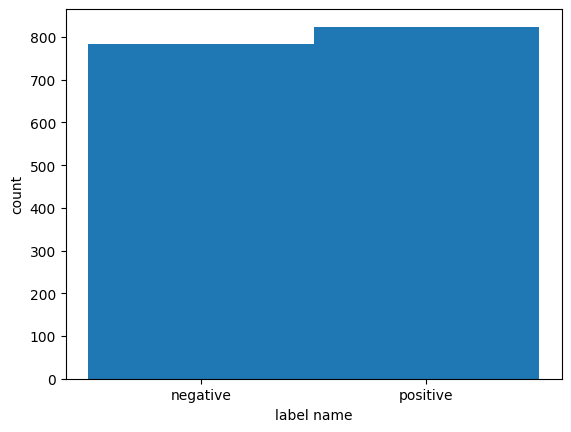

In [19]:
def visualize_lables(dataset: Dataset):
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("label name")
    plt.ylabel("count")
    plt.show()

visualize_lables(train_dataset) 
visualize_lables(valid_dataset) 

In [20]:
from transformers import BatchEncoding

def preprocess_text_classification(example: dict[str, str | int]) -> BatchEncoding:
    encoded_example = tokenizer(example["sentence"], max_length=512)
    encoded_example["labels"] = example["label"]

    return encoded_example

In [23]:
encoded_train_dataset = train_dataset.map(preprocess_text_classification, remove_columns=train_dataset.column_names, batched=True)
encoded_valid_dataset = valid_dataset.map(preprocess_text_classification, remove_columns=valid_dataset.column_names)

Map: 100%|██████████| 1608/1608 [00:00<00:00, 6830.49 examples/s]


In [22]:
print(encoded_train_dataset[0])

{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
batch_inputs = data_collator(encoded_train_dataset[0:4])

In [28]:
batch_inputs

{'input_ids': tensor([[    2,   478,  7139, 15269,   441,   456, 13123, 21311, 12671,   385,
         12651,  7065, 12485, 12488, 13781,   461,   457, 13030,   464,   461,
            29,    29,    29,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    2, 15028,   464,  2806,   484, 30908,   456, 19730,   385,  2724,
          7998, 12505,  6483,   430, 14165,   456, 31265,  7106,   460,  7373,
           458, 13513,  7241, 13320, 20831,  7951,   385, 12651,  7065, 14176,
         13053,   484, 17941, 12494,   385,     3],
        [    2,  4097,  7228,   384,  4097,  7203, 12494,   385,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    2, 19890,  4391,   430, 26297,   456,   431, 16328,   385, 15206,
          7228,   460,    29,    29,    

In [32]:
from transformers import AutoModelForSequenceClassification
class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,
    id2label=id2label,
)

loading configuration file config.json from cache at /Users/satsuki/.cache/huggingface/hub/models--cl-tohoku--bert-base-japanese-v3/snapshots/65243d6e5629b969c77309f217bd7b1a79d43c7e/config.json
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-v3",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32768
}

loading weights file pytorch_model.bin fro

In [34]:
model.forward(**data_collator(encoded_train_dataset[:4]))

SequenceClassifierOutput(loss=tensor(0.8075, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2869, -0.2644],
        [ 0.1715,  0.0095],
        [ 0.0040,  0.1524],
        [ 0.2233, -0.2968]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [56]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=4,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=4,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=False,  # 自動混合精度演算の有効化
    no_cuda=True,
)

/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/training_args.py:1540: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
import numpy as np 

def compute_accuracy(eval_pred: tuple[np.ndarray, np.ndarray])-> dict[str, float]:
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"accuracy", (predictions==labels).mean()}

In [71]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset[0:100],
    eval_dataset=encoded_valid_dataset[:100],
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,

)
trainer.train()

  0%|          | 0/3 [01:12<?, ?it/s]
***** Running training *****
  Num examples = 4
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 3
  Number of trainable parameters = 111,208,706
  0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 2

In [54]:
len(encoded_train_dataset) 

20149

In [75]:
from huggingface_hub import login
login()


In [2]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cpu")
     

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [5]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/wrime-sentiment", split="validation"
)

In [16]:
from tqdm import tqdm
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset.select([i for i in range(len(valid_dataset)) if i %10 == 0]))):
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    true_label = class_label.int2str(example["label"])

    results.append(
        {
            "example_id": i,
            "pred_prod": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

161it [00:31,  5.12it/s]


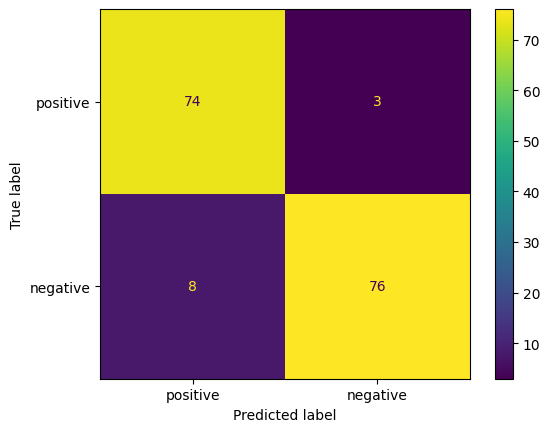

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names
)

ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

In [21]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prod"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    # print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")
     

レビュー文：書けない
予測：negative
正解：positive
----------------
レビュー文：31のスーパーチョコミント食べたい でもどこもテナント入居してるビル自体が休業中でやってないのだけど。
予測：negative
正解：positive
----------------
レビュー文：テレビで3曲とも聞いた。音もこっちがいいかも。
スマホと全然、すべてが違った。
予測：negative
正解：positive
----------------
レビュー文：本当に邪魔だからどっか行ってほしい。
予測：positive
正解：negative
----------------
レビュー文：ほんと、考察がすごい。
自分だけではわからなかったこととか多すぎる。
他のことにも援用できる。
物の見方が広がる。
予測：positive
正解：negative
----------------


In [22]:
from transformers.trainer_utils import set_seed
set_seed(32)

In [23]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/JGLUEのリポジトリから
# JNLIのデータを読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)
# pprintで見やすく表示する
pprint(train_dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'label': 2,
 'sentence1': '二人の男性がジャンボジェット機を見ています。',
 'sentence2': '2人の男性が、白い飛行機を眺めています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '100124-104404-104405'}


In [24]:
print(train_dataset.features["label"])

ClassLabel(names=['entailment', 'contradiction', 'neutral'], id=None)


In [25]:
from transformers import AutoTokenizer

model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading file vocab.txt from cache at /Users/satsuki/.cache/huggingface/hub/models--cl-tohoku--bert-base-japanese-v3/snapshots/65243d6e5629b969c77309f217bd7b1a79d43c7e/vocab.txt
loading file spiece.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/satsuki/.cache/huggingface/hub/models--cl-tohoku--bert-base-japanese-v3/snapshots/65243d6e5629b969c77309f217bd7b1a79d43c7e/tokenizer_config.json
loading file tokenizer.json from cache at None
/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings

In [26]:
from transformers import BatchEncoding

def preprocess_text_pair_classification(example: dict[str, str|int])-> BatchEncoding:
    encoded_example = tokenizer(
        example["sentence1"], example["sentence2"], max_length=128
    )
    encoded_example["labels"] = example["label"]
    return encoded_example

In [27]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=train_dataset.column_names,
)

encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

Parameter 'function'=<function preprocess_text_pair_classification at 0x1985f71a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/20073 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

In [28]:
print(encoded_train_dataset[0])


{'input_ids': [2, 14269, 464, 13341, 430, 27914, 16753, 3107, 500, 5538, 456, 422, 12995, 385, 3, 33, 680, 464, 13341, 430, 384, 16517, 13208, 3107, 500, 29887, 456, 422, 12995, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}


In [32]:
tokenizer.convert_ids_to_tokens(encoded_train_dataset[0]["input_ids"])

['[CLS]',
 '二人',
 'の',
 '男性',
 'が',
 'ジャンボ',
 'ジェット',
 '機',
 'を',
 '見',
 'て',
 'い',
 'ます',
 '。',
 '[SEP]',
 '2',
 '人',
 'の',
 '男性',
 'が',
 '、',
 '白い',
 '飛行',
 '機',
 'を',
 '眺め',
 'て',
 'い',
 'ます',
 '。',
 '[SEP]']

In [29]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 31]),
 'input_ids': torch.Size([4, 31]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 31])}


In [33]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)
     

loading configuration file config.json from cache at /Users/satsuki/.cache/huggingface/hub/models--cl-tohoku--bert-base-japanese-v3/snapshots/65243d6e5629b969c77309f217bd7b1a79d43c7e/config.json
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-v3",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "contradiction",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 1,
    "entailment": 0,
    "neutral": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

BertForSequenceClassification


In [34]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))


SequenceClassifierOutput(loss=tensor(1.2049, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1307,  0.1713, -0.0987],
        [ 0.1554,  0.1772, -0.0990],
        [ 0.0330,  0.0935, -0.0744],
        [ 0.0430,  0.0790, -0.0806]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [36]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jnli",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=False,  # 自動混合精度演算の有効化
    no_cuda=True,
)
     

/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/training_args.py:1540: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [37]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [38]:

from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

***** Running training *****
  Num examples = 20,073
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,884
  Number of trainable parameters = 111,209,475


  0%|          | 0/1884 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

In [2]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリから
# データを読み込む
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")
# pprintで見やすく表示する
pprint(train_dataset[0])

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [3]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)
     

BertJapaneseTokenizer


/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:

from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

In [5]:

encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)
     

Parameter 'function'=<function preprocess_text_classification at 0x1487b9b20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/20149 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1608 [00:00<?, ? examples/s]

In [6]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(base_model).__name__)

/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [8]:
import peft

peft_config = peft.LoraConfig(
    task_type=peft.TaskType.SEQ_CLS,  # モデルが解くタスクのタイプを指定
    r=8,  # 差分行列のランク
    lora_alpha=32,  #  LoRA層の出力のスケールを調節するハイパーパラメータ
    lora_dropout=0.1,  # LoRA層に適用するドロップアウト
    inference_mode=False,  # 推論モードの設定（今回は学習時なのでFalse）
)
model = peft.get_peft_model(base_model, peft_config)
print(type(model).__name__)

PeftModelForSequenceClassification


In [10]:
model.print_trainable_parameters()

trainable params: 296,450 || all params: 111,505,156 || trainable%: 0.2659


In [11]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))


SequenceClassifierOutput(loss=tensor(0.8075, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2869, -0.2644],
        [ 0.1715,  0.0095],
        [ 0.0040,  0.1524],
        [ 0.2233, -0.2968]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime_lora",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-4,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=False,  # 自動混合精度演算の有効化
    no_cuda=True,
)


/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/satsuki/github/tech-notes/llm-book/src/.venv/lib/python3.11/site-packages/transformers/training_args.py:1540: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [13]:

import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}
     

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

  0%|          | 0/1890 [00:00<?, ?it/s]

KeyboardInterrupt: 